In [1]:
import os
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

2024-01-31 11:47:06.566953: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-31 11:47:06.567102: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-31 11:47:06.707160: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [15]:
folder_path='/kaggle/input/utkface-new/UTKFace'

In [16]:
age=[]
gender=[]
img_path=[]
for file in os.listdir(folder_path):
  age.append(int(file.split('_')[0]))
  gender.append(int(file.split('_')[1]))
  img_path.append(file)

In [17]:
len(age)

23708

In [18]:
df = pd.DataFrame({'age':age,'gender':gender,'img':img_path})

In [19]:
df.head()

,age,gender,img
0,26,0,26_0_2_20170104023102422.jpg.chip.jpg
1,22,1,22_1_1_20170112233644761.jpg.chip.jpg
2,21,1,21_1_3_20170105003215901.jpg.chip.jpg
3,28,0,28_0_0_20170117180555824.jpg.chip.jpg
4,17,1,17_1_4_20170103222931966.jpg.chip.jpg


# splitting in to train and test dataframes and using first 20000 for train and remaining for test

In [20]:
train_df = df.sample(frac=1,random_state=0).iloc[:20000]
test_df = df.sample(frac=1,random_state=0).iloc[20000:]

In [22]:
train_df.shape

(20000, 3)

In [23]:
test_df.shape

(3708, 3)

# Data Augmentation

In [24]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

# y_col will return to outputs(multi output)

In [25]:
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    directory=folder_path,
                                                    x_col='img',
                                                    y_col=['age','gender'],
                                                    target_size=(200,200),
                                                    class_mode='multi_output')

test_generator = test_datagen.flow_from_dataframe(test_df,
                                                    directory=folder_path,
                                                    x_col='img',
                                                    y_col=['age','gender'],
                                                    target_size=(200,200),
                                                  class_mode='multi_output')

Found 20000 validated image filenames.
Found 3708 validated image filenames.


In [26]:
from keras.applications.resnet50 import ResNet50
from keras.layers import *
from keras.models import Model

# TANSFER LEARNING

In [27]:
resnet = ResNet50(include_top=False, input_shape=(200,200,3))

94765736/94765736 [==============================] - 3s 0us/step


# Using pre-trained convolutional base of ResNet

In [28]:
resnet = ResNet50(include_top=False, input_shape=(200,200,3))

resnet.trainable=False

output = resnet.layers[-1].output

flatten = Flatten()(output)

dense1 = Dense(512, activation='relu')(flatten)
dense2 = Dense(512,activation='relu')(flatten)

dense3 = Dense(512,activation='relu')(dense1)
dense4 = Dense(512,activation='relu')(dense2)

output1 = Dense(1,activation='linear',name='age')(dense3)
output2 = Dense(1,activation='sigmoid',name='gender')(dense4)

In [29]:
model = Model(inputs=resnet.input,outputs=[output1,output2])

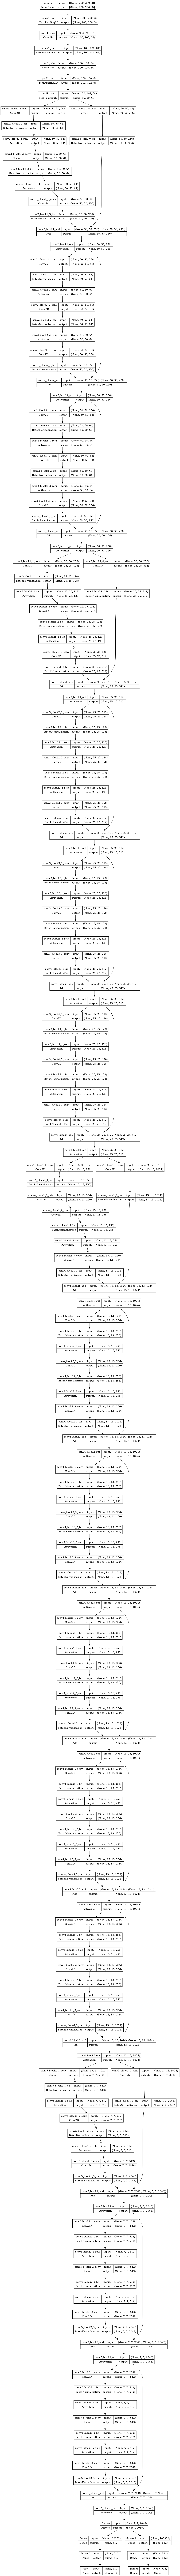

In [33]:
from keras.utils import plot_model
plot_model(model,show_shapes=True)

In [30]:
model.compile(optimizer='adam', loss={'age': 'mae', 'gender': 'binary_crossentropy'}, metrics={'age': 'mae', 'gender': 'accuracy'},loss_weights={'age':1,'gender':99})

In [32]:
history=model.fit(train_generator, batch_size=32, epochs=10, validation_data=test_generator)

Epoch 1/10
625/625 [==============================] - 304s 486ms/step - loss: 83.9900 - age_loss: 15.1161 - gender_loss: 0.6957 - age_mae: 15.1161 - gender_accuracy: 0.5178 - val_loss: 83.4528 - val_age_loss: 14.9768 - val_gender_loss: 0.6917 - val_age_mae: 14.9768 - val_gender_accuracy: 0.5272
Epoch 2/10
625/625 [==============================] - 232s 370ms/step - loss: 83.5760 - age_loss: 14.9761 - gender_loss: 0.6929 - age_mae: 14.9761 - gender_accuracy: 0.5216 - val_loss: 82.7275 - val_age_loss: 14.2123 - val_gender_loss: 0.6921 - val_age_mae: 14.2123 - val_gender_accuracy: 0.5272
Epoch 3/10
625/625 [==============================] - 234s 375ms/step - loss: 83.4597 - age_loss: 14.9035 - gender_loss: 0.6925 - age_mae: 14.9035 - gender_accuracy: 0.5217 - val_loss: 83.5081 - val_age_loss: 14.9683 - val_gender_loss: 0.6923 - val_age_mae: 14.9683 - val_gender_accuracy: 0.5272
Epoch 4/10
625/625 [==============================] - 232s 371ms/step - loss: 83.4029 - age_loss: 14.7904 - gend

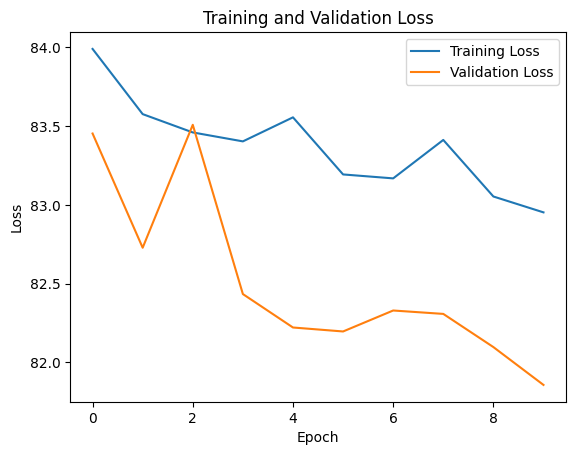

In [36]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Testing on Untrained Images

In [ ]:
from keras.preprocessing import image
import numpy as np

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(200, 200))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the image

    return img_array

# Replace 'path_to_untrained_image.jpg' with the actual path to your untrained image
untrained_image_path = 'path_to_untrained_image.jpg'

# Preprocess the untrained image
untrained_img = preprocess_image(untrained_image_path)

# Make predictions
age_pred, gender_pred = model.predict(untrained_img)

# Display the predictions
print("Predicted Age:", age_pred[0][0])
print("Predicted Gender (0 for Male, 1 for Female):", round(gender_pred[0][0]))
